# LSTM Baseline

In [1]:
# Enable autoreload of local Python modules (e.g., models)
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import jax
import jax.numpy as jnp
import optax
import time

# save checkpoints using orbax
from pathlib import Path

# local imports
import models.LSTM as models
import utils.generation as generation
import utils.eval as eval

# utilities
# Import our new utilities
from utils import (
    load_config,
    print_config,
    plot_training_curves,
    analyze_training_performance,
    save_collected_checkpoints,
    logger,
    test_checkpoint,
    load_checkpoint,
)

# Load data

In [3]:
# load the ./data/text8_train.txt and ./data/text8_test.txt files
with open("./data/text8_train.txt", "r") as f:
    train_text_full = f.read()
with open("./data/text8_test.txt", "r") as f:
    test_text = f.read()

train_ratio = 0.95
N = len(train_text_full)
cut = int(N * train_ratio)

train_text = train_text_full[:cut]  # training text
val_text = train_text_full[cut:]  # validation text
# print the length of the training text and test text
print(f"Length of training text: {len(train_text):_} characters")
print(f"Length of validation text: {len(val_text):_} characters")
print(f"Length of test text: {len(test_text):_} characters")

Length of training text: 85_500_000 characters
Length of validation text: 4_500_000 characters
Length of test text: 5_000_000 characters


In [4]:
# Build vocabulary (lowercase + space + a few punctuations)
char_set = list("abcdefghijklmnopqrstuvwxyz ")
char_to_int = {ch:i for i,ch in enumerate(char_set)}
int_to_char = {i:ch for ch,i in char_to_int.items()}


def encode(s):
    """Encode string to array of integers"""
    ids = [char_to_int[c] for c in s]
    return np.array(ids, dtype=np.uint8)  # use np.uint8 to save space

In [5]:
# encode the text
train_text_int = encode(train_text)
val_text_int = encode(val_text)
test_text_int = encode(test_text)

In [6]:
# sanity check: display a few random characters from the training text
T = 128
for _ in range(5):
    # choose random position in text
    N = np.random.randint(low=0, high=len(train_text)-T)
    print(train_text[N:N+T])
    print()

ory of world war ii ace butch voris and the creation of the blue angels the navy flight demonstration squadron the blue angels u

ending up in rivers or the ocean according to the ocean conservancy these condoms cover the coral reefs and smothers sea grass a

one nine nine five five two eight pp isbn zero one four zero one eight six nine five six aleksandr isayevich solzhenitsyn the gu

 fermented drinks finland sahti a traditional finnish beer japan sake a primarily rice based fermented drink similar in many res

nning the contest arnold s goal was to become the greatest bodybuilder in the world which meant becoming mr olympia his first at



## Load Conifguration

In [12]:
CONFIG_PATH = "./configs/baseline.yaml"
# Load configuration
config = load_config(CONFIG_PATH)
print_config(config)

# Initialize random seed
key = jax.random.key(config.training.seed)


CONFIGURATION
model_name: LSTM-baseline
model:
  vocab_size: 27
  hidden_size: 256
  n_heads: 4
  n_layers: 4
  max_len: 128
  dropout: 0.1
loss:
  LABEL_SMOOTHING: True
  ls_eps: 0.05
  entropy_lambda: 0.0
  tail_scheme: linear
scheduler:
  warmup_iters: 2000
  init_value: 0.0
  end_value: 0.0
training:
  batch_size: 128
  sequence_length: 128
  learning_rate: 0.0003
  epochs: 5000
  validation_interval: 500
  stage_checkpoint_interval: 10000
  seed: 4212
evaluation:
  sample: True
  seed: 4212
  prompt: hello my fri
  gen_len: 1000
  temperature: 0.7
  self_belu_n_grams: 4
  self_belu_n_samples: 20
output:
  checkpoint_dir: ./checkpoints
  results_dir: ./runs



## Create a basic LSTM model

In [13]:
def create_train_state(rng, config):
    # create a basic Transformer model
    model = models.CharLSTM(
        vocab_size=config.model.vocab_size,
        hidden_size=config.model.hidden_size,
        n_layers=config.model.n_layers,
        dropout=config.model.dropout,
        max_len=config.model.max_len,
    )

    # create a dummy input for initialization
    dummy = jnp.zeros((1, min(16, config.model.max_len)), dtype=jnp.int32)
    # pass the dummy input to the model to initialize the parameters
    params = model.init({"params": rng}, dummy, train=True)["params"]
    return model, params


def count_params(params):
    return sum(x.size for x in jax.tree_util.tree_leaves(params))

In [14]:
model, params = create_train_state(key, config)
num_params = count_params(params)
print(f"Model created: {config.model_name}")
print(f"Number of parameters: {num_params:_}")

2025-11-21 14:24:39.009891: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


Model created: LSTM-baseline
Number of parameters: 2_115_072


In [15]:
# sanity check: create a batch of data & run a forward pass
B, T = 4, 32
batch = jax.random.randint(
    key=key,
    shape=(B, T), minval=0, maxval=len(char_set))
logits = model.apply({"params": params}, batch, train=False)

print("batch shape:", batch.shape)  # (B, T)
print("logits shape:", logits.shape)  # (B, T, vocab_size)

2025-11-21 14:24:43.905529: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


batch shape: (4, 32)
logits shape: (4, 32, 27)


## Loss function

In [16]:
@jax.jit
def loss_and_metrics(logits, targets):

    B, T, V = logits.shape

    # position weights mode
    # linear: w(t) = 0.3 + 0.7 * (t / T)
    # sqrt: w(t) = 0.1 + 0.9 * sqrt(t / T)
    # none: w(t) = 1.0
    tail_scheme = "linear"

    if config.loss.LABEL_SMOOTHING and config.loss.ls_eps > 0.0:
        tgt = jax.nn.one_hot(targets, V)
        tgt = (1.0 - config.loss.ls_eps) * tgt + (config.loss.ls_eps / V)
        per_pos_ce = optax.softmax_cross_entropy(logits, tgt)
    else:
        per_pos_ce = optax.softmax_cross_entropy_with_integer_labels(
            logits.reshape(-1, V), targets.reshape(-1)
        ).reshape(B, T)

    # Position weights: emphasize later positions, but don't discard early ones
    if tail_scheme == "linear":
        w = jnp.linspace(0.3, 1.0, T)
    elif tail_scheme == "sqrt":
        w = 0.1 + 0.9 * jnp.sqrt(jnp.linspace(0.0, 1.0, T))
    else:
        w = jnp.ones((T,))
    w = w[None, :]

    # Weighted loss
    loss_weighted = (per_pos_ce * w).sum() / (B * w.sum())

    # Entropy bonus to encourage less-peaked distributions
    if config.loss.entropy_lambda > 0.0:
        logp = jax.nn.log_softmax(logits, axis=-1)
        p = jnp.exp(logp)
        entropy = -(p * logp).sum(-1).mean()
        train_loss = loss_weighted - config.loss.entropy_lambda * entropy
    else:
        train_loss = loss_weighted

    # Metrics for curve comparison (do not involved in backprop)
    # Mean CE over all positions (unweighted, for alignment with literature/old results)
    loss_all = eval.loss_all(logits, targets)
    loss_last = eval.cross_entropy_last_token_only(logits, targets)
    acc_all, acc_last = eval.accuracy(logits, targets)
    perplexity, avg_loss = eval.perplexity(logits, targets)
    bpc = eval.bits_per_character(avg_loss)
    avg_entropy, entropy_by_position = eval.prediction_entropy(logits)

    # ECE
    ece, calibration_data = eval.expected_calibration_error(logits, targets)

    metrics = {
        "loss_train": train_loss,
        "loss_all": loss_all,
        "loss_last": loss_last,
        "acc": acc_all,
        "acc_last": acc_last,
        "perplexity": perplexity,
        "bpc": bpc,
        "pred_entropy": avg_entropy,
        "ece": [ece, calibration_data],
    }

    return train_loss, metrics

## Optimization step

In [17]:
# create an update function
def train_step(params, step_rng, opt_state, x, y, tx):
    """Single optimization step using optax optimizer.

    Args:
      params: pytree of model parameters.
      opt_state: optax optimizer state corresponding to `params`.
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
      tx: optax.GradientTransformation (already initialized).

    Returns:
      new_params: updated parameters after one gradient step.
      new_opt_state: updated optimizer state.
      metrics: dict of scalar metrics (loss, acc).
    """

    def loss_fn(params):
        logits = model.apply({"params": params}, x, train=True, rngs={"dropout": step_rng})
        loss, metrics = loss_and_metrics(logits, y)
        return loss, metrics

    # compute gradients (loss is scalar, metrics is auxiliary)
    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # optax update: compute parameter updates and new optimizer state
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, metrics


# jit: last argument should be static because it is an object
train_step = jax.jit(train_step, static_argnames=("tx",))

## Batch creation

In [18]:
# create a batch from the training data
def get_batch(text_int, B, T):
    """Create a random batch of data from text_int.

    Args:
      text_int: 1D array of token ids.
      B: batch size (number of sequences).
      T: sequence length (number of tokens per sequence).

    Returns:
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
    """
    # choose random starting indices for each sequence in the batch
    ix = np.random.randint(0, len(text_int) - T, size=B)
    # inputs are text from i to i+T
    x = np.stack([text_int[i:i+T] for i in ix])
    # targets are text from i+1 to i+T+1
    y = np.stack([text_int[i+1:i+T+1] for i in ix])
    return jnp.array(x, dtype=jnp.int32), jnp.array(y, dtype=jnp.int32)

## Optimizer creation

In [20]:
# learning rate scheduler
lr_schedule = optax.warmup_cosine_decay_schedule(
    init_value=config.scheduler.init_value,
    peak_value=config.training.learning_rate,
    warmup_steps=config.scheduler.warmup_iters,
    decay_steps=max(1, config.training.epochs - config.scheduler.warmup_iters),
    end_value=config.scheduler.end_value,
)

# Create AdamW optimizer (Optax)
tx = optax.chain(
    # gradient clipping (optiaonal)
    optax.clip_by_global_norm(1.0),
    optax.adamw(
        learning_rate=lr_schedule,
        b1=0.9,
        b2=0.95,
        eps=1e-8,
        weight_decay=0.1,
    ),
)

# Initialize optimizer state for current params
opt_state = tx.init(params)

print("Optimizer initialized: AdamW with warmup-cosine schedule")

Optimizer initialized: AdamW with warmup-cosine schedule


## Model Training

In [24]:
CKPT_DIR = Path(f"{config.output.checkpoint_dir}/{config.model_name}").resolve()
CKPT_DIR.mkdir(parents=True, exist_ok=True)

STAGE_DIR = CKPT_DIR / 'stage'
BEST_DIR = CKPT_DIR / 'best'
STAGE_DIR.mkdir(exist_ok=True)
BEST_DIR.mkdir(exist_ok=True)

print(f"Checkpoint directory: {CKPT_DIR}")

Checkpoint directory: /home/users/tampbench/jinhang/CharacterLLM/checkpoints/LSTM-baseline


In [25]:
metrics_logger = logger.Logger(config.training.epochs)
print(f"Logger initialized: {metrics_logger}")

B = config.training.batch_size
T = config.training.sequence_length
val_interval = config.training.validation_interval

time_train_history = []
time_val_history = []

checkpoints_to_save = {
    'stage': [],
    'best_loss_all': None,
    'best_acc': None,
}

rng = jax.random.PRNGKey(config.training.seed)

print("Training initialization complete")
print(f"- Number of Epochs: {config.training.epochs:,}")
print(f"- Batch size: {config.training.batch_size}")
print(f"- Validation interval: {config.training.validation_interval}")

Logger initialized: Logger(train_steps=0, eval_steps=0)
Training initialization complete
- Number of Epochs: 5,000
- Batch size: 128
- Validation interval: 500


In [26]:
time_start = time.time()
for it in range(config.training.epochs):
    key, step_key = jax.random.split(key)
    batch = get_batch(train_text_int, B, T)
    input, target = batch[0], batch[1]
    params_new, opt_state_new, metrics = train_step(params, step_key, opt_state, input, target, tx)

    # update params and opt_state
    params = params_new
    opt_state = opt_state_new

    metrics_logger.log_train(metrics)

    time_train_history.append(time.time() - time_start)

    if it % val_interval == 0 or it == config.training.epochs - 1:
        time_since_start = time.time() - time_start

        # compute loss on validation set
        B_val, T_val = 1024, 32
        val_batch = get_batch(val_text_int, B_val, T_val)
        val_input, val_target = val_batch[0], val_batch[1]
        val_logits = model.apply({"params": params}, val_input, train=False)

        # validation metrics
        val_weighted_loss, val_metrics = loss_and_metrics(val_logits, val_target)

        # record validation metrics
        metrics_logger.log_eval(it, val_metrics)
        time_val_history.append(time_since_start)

        # print validation metrics
        metrics_logger.print_metrics(time_since_start)

        is_best_loss_all, is_best_acc, is_best_acc_last = metrics_logger.isBest(val_metrics)

        # save checkpoints
        checkpoint_state = {
            'params': params,
            'opt_state': opt_state,
            'rng': rng,
            'step': it,
            'val_loss': float(val_metrics['loss_all']),
            'val_bpc': float(val_metrics['bpc']),
            'val_perplexity': float(val_metrics['perplexity']),
            'val_acc': float(val_metrics['acc']),
            'val_acc_last': float(val_metrics['acc_last']),
            'ECE': float(val_metrics['ece'][0]),

        }

        if (it + 1) % config.training.stage_checkpoint_interval == 0 or (it + 1) == config.training.epochs:
            checkpoints_to_save['stage'].append((it, checkpoint_state.copy()))
            print(f"\t \t Saved stage checkpoint @ {it:,}")

        if is_best_loss_all:
            checkpoints_to_save['best_loss_all'] = (it, checkpoint_state.copy())
            print(f"\t \t Saving best loss checkpoint at iteration {it}...")

        if is_best_acc:
            checkpoints_to_save['best_acc'] = (it, checkpoint_state.copy())
            print(f"\t \t Saving best accuracy checkpoint at iteration {it}...")

        if is_best_acc_last:
            checkpoints_to_save['best_acc_last'] = (it, checkpoint_state.copy())
            print(f"\t \t Saving best last-character accuracy checkpoint at iteration {it}...")

total_time = time.time() - time_start


iteration 0  time: 4.8 seconds
	 	 loss (weighted train): 3.2957
	 	 loss (train :: test): 3.2957 :: 3.2957
	 	 loss (last character): 3.2955
	 	 accuracy: 5.3%
	 	 accuracy (last character): 6.1%
	 	 perplexity: 26.9960
	 	 bits-per-character: 4.7547
	 	 ECE: 0.0155
	 	 pred_entropy: 3.2958
	 	 Saving best loss checkpoint at iteration 0...
	 	 Saving best accuracy checkpoint at iteration 0...
	 	 Saving best last-character accuracy checkpoint at iteration 0...

iteration 500  time: 28.5 seconds
	 	 loss (weighted train): 2.8976
	 	 loss (train :: test): 2.8569 :: 2.8783
	 	 loss (last character): 2.8248
	 	 accuracy: 17.5%
	 	 accuracy (last character): 17.1%
	 	 perplexity: 17.7831
	 	 bits-per-character: 4.1524
	 	 ECE: 0.0155
	 	 pred_entropy: 2.9523
	 	 Saving best loss checkpoint at iteration 500...
	 	 Saving best accuracy checkpoint at iteration 500...
	 	 Saving best last-character accuracy checkpoint at iteration 500...

iteration 1000  time: 50.3 seconds
	 	 loss (weighted 

In [27]:
save_collected_checkpoints(checkpoints_to_save, STAGE_DIR, BEST_DIR)

SAVING CHECKPOINTS
	 Saving stage checkpoint 1 (step 4,999)...
	 Saved (loss: 1.6777)
	 Saving best loss checkpoint (step 4,000)...


	 Saved (loss: 1.6543)
	 Saving best accuracy checkpoint (step 4,000)...
	 Saved (acc: 50.35%)
	 Saving best last-char accuracy checkpoint (step 3,000)...
	 Saved (acc_last: 52.54%)
ALL CHECKPOINTS SAVED


## Performance Analysis

In [28]:
results_dir = Path(f"{config.output.results_dir}/{config.model_name}").resolve()
results_dir.mkdir(parents=True, exist_ok=True)

results = analyze_training_performance(
    metrics_logger=metrics_logger,
    total_time=total_time,
    niter=config.training.epochs,
    n_final=10,
    save_results=True,
    results_path=str(results_dir / 'training_results.json')
)


PERFORMANCE ANALYSIS

Best Test Loss:    1.6543  (at iteration 4,000)
Best Last Char Loss:    1.5725  (at iteration 3,000)
Best Test Acc:     50.35%  (at iteration 4,000)
Best Last Char Acc: 52.54%  (at iteration 3,000)

Final Average (last 10 checkpoints):
  Test Loss:       1.8995 ± 0.3789
  Last Char Loss:  1.8338 ± 0.3903
  Test Accuracy:   43.43% ± 10.33%
  Last Char Acc:   45.91% ± 11.09%

Training Time:
  Total:           227.3 seconds (3.8 minutes)
  Per Iteration:   0.0455 seconds
  Total Iterations: 5,000

Convergence Analysis:
  Still Improving:    Yes

Results saved to '/home/users/tampbench/jinhang/CharacterLLM/runs/LSTM-baseline/training_results.json'


## Ploting


Figure saved to '/home/users/tampbench/jinhang/CharacterLLM/runs/LSTM-baseline/training_curves.pdf'


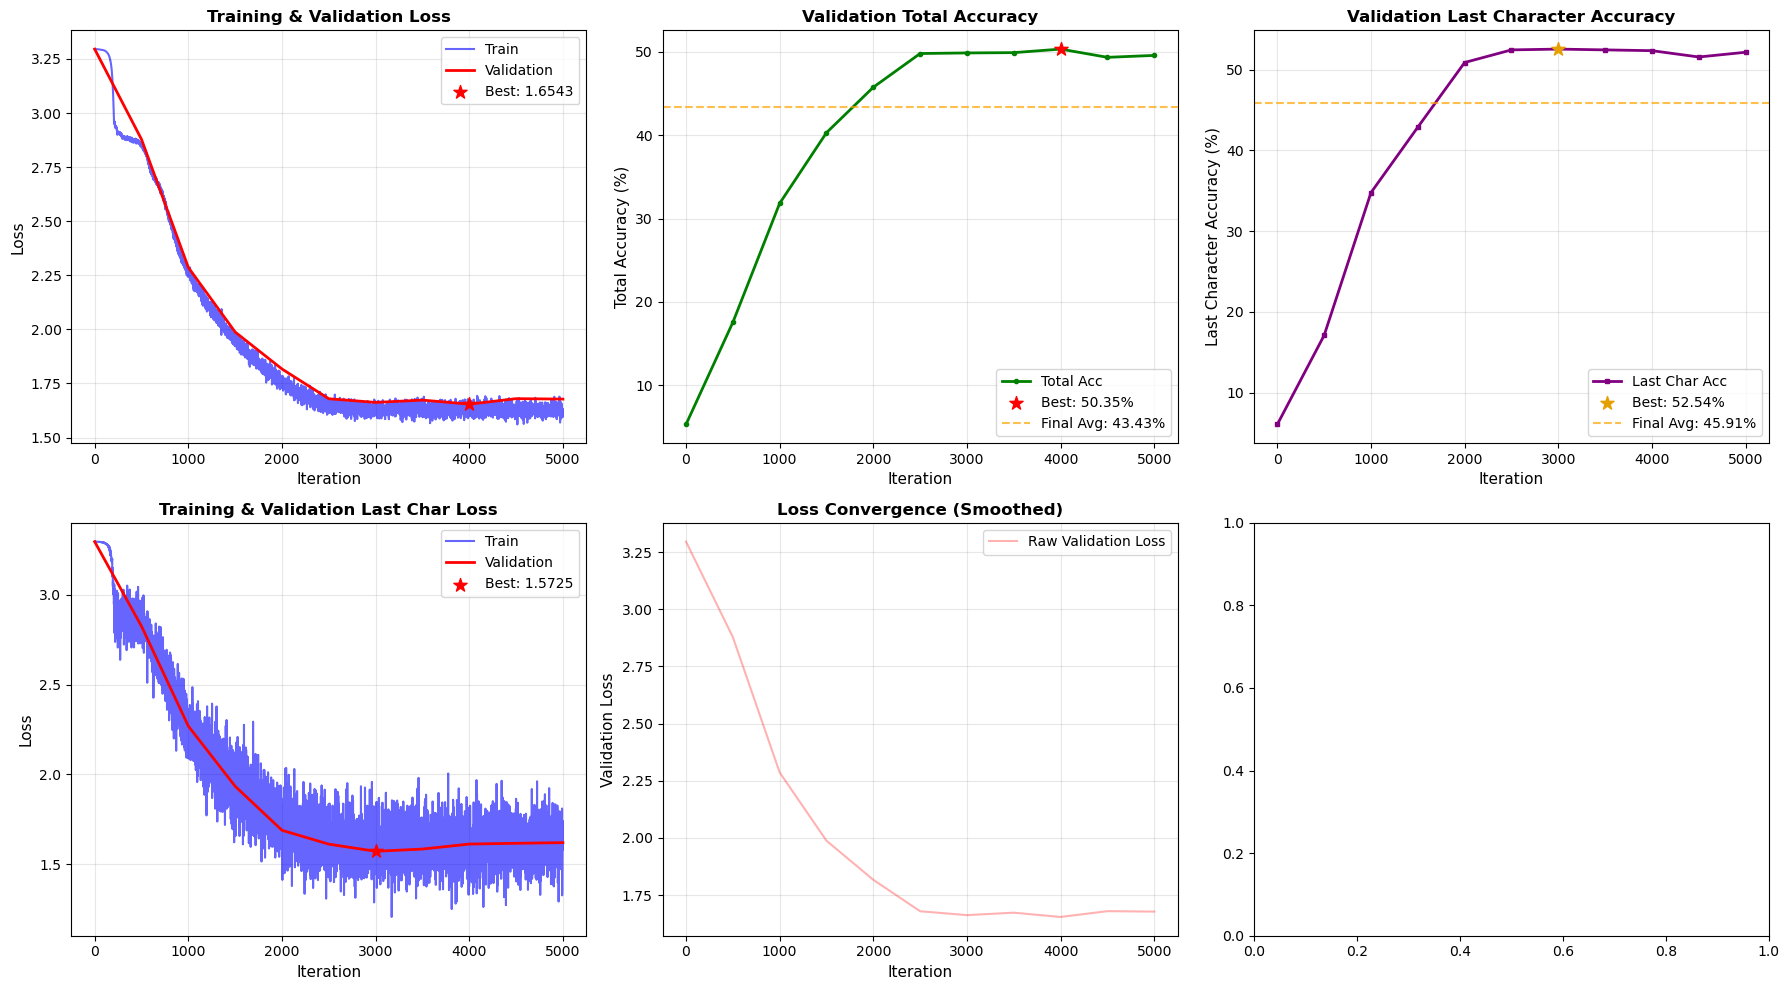

In [29]:
plot_training_curves(
    metrics_logger=metrics_logger,
    save_path=str(results_dir / 'training_curves.pdf')
)

## Evaluation

In [ ]:
checkpoint_types = [
    ('best_loss_all_', 'Best Loss'),
    ('best_acc_total_', 'Best Accuracy'),
    ('best_acc_last_', 'Best Last-Char Accuracy'),
]

for prefix, name in checkpoint_types:
    print(f"\n{name}...")
    try:
        # load checkpoint
        checkpoint = load_checkpoint(prefix, name, BEST_DIR, STAGE_DIR)
        params = checkpoint['params']

        # test checkpoint
        test_metrics = test_checkpoint(model, params, test_text_int, int_to_char)
        self_belu_score = eval.self_bleu(
            model, config, int_to_char, char_to_int, char_set, params,
            prompt=config.evaluation.prompt,
            gen_len=config.evaluation.gen_len,
            temperature=config.evaluation.temperature,
            sample=config.evaluation.sample,
            seed=config.evaluation.seed,
            n_grams=config.evaluation.self_belu_n_grams,
            n_samples=config.evaluation.self_belu_n_samples,
            ngram_size=None
        )

        # generate text
        rng = jax.random.PRNGKey(config.evaluation.seed)
        prompt_int = jnp.array(
            [[char_to_int.get(c, len(char_set)) for c in config.evaluation.prompt.lower()[:config.model.max_len]]],
            dtype=jnp.int32
        )
        out_ids = generation.generate_tokens(
            model, params, rng, prompt_int, config.evaluation.gen_len,
            block_size=config.model.max_len,
            temperature=config.evaluation.temperature,
            sample=config.evaluation.sample,
            ngram_size=None
        )
        generated_text = ''.join(int_to_char.get(int(x), '?') for x in list(out_ids[0]))
        full_text = config.evaluation.prompt + generated_text

        # save to file
        filename = prefix.replace('_', '') + '.txt'
        output_path = results_dir / filename

        with open(output_path, 'w') as f:
            f.write(f"{name}\n")
            f.write("\n")
            f.write(f"Step: {checkpoint['step']}\n")
            f.write(f"Validation Loss: {checkpoint['val_loss']:.4f}\n")
            f.write(f"Validation BPC: {checkpoint['val_bpc']:.4f}\n")
            f.write(f"Validation Perplexity: {checkpoint['val_perplexity']:.4f}\n")
            f.write(f"Validation Acc (Last): {100*checkpoint['val_acc_last']:.2f}%\n")
            f.write(f"Validation Acc: {100*checkpoint['val_acc']:.2f}%\n")
            f.write(f"Validation ECE: {checkpoint['ECE']:.4f}\n")
            f.write("\n")
            f.write(f"Test Perplexity: {test_metrics[0]:.4f}\n")
            f.write(f"Test BPC: {test_metrics[1]:.4f}\n")
            f.write(f"Test Acc: {100*test_metrics[2]:.2f}%\n")
            f.write(f"Test Acc (Last): {100*test_metrics[3]:.2f}%\n")
            f.write(f"Test Avg Rare Acc: {100*test_metrics[4]:.2f}%\n")
            f.write(f"Test Avg Common Acc: {100*test_metrics[5]:.2f}%\n")
            f.write(f"Test Avg Distinct: {test_metrics[6]:.2f}\n")
            f.write(f"Test Coherence: {test_metrics[7]:.2f}\n")
            f.write(f"Self-BLEU-{config.evaluation.self_belu_n_grams}: {self_belu_score:.4f}\n")
            f.write("\n")
            f.write(full_text)

        print(f"\tSaved to {output_path}")
        print(f"\tPreview: {full_text[:100]}...")

    except Exception as e:
        print(f"\tError: {e}")